In [1]:
!nvidia-smi

Tue Nov  3 18:58:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install u8darts[all]

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values

from darts.dataprocessing.transformers import MissingValuesFiller

In [7]:
def transform_data(series, train, val):
    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    ts_transformed = transformer.transform(series)
    return ts_transformed, train_transformed, val_transformed

def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    plt.title('R2: {}'.format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend();

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


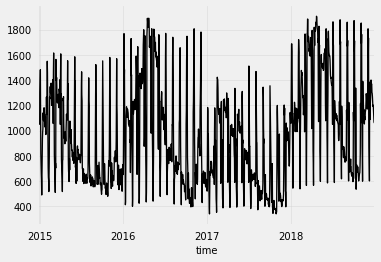

In [8]:
# Read data:
df = pd.read_csv('/tmp/energy_dataset.csv')
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time']= df.time.dt.tz_localize(None)

df_day_avg = df.groupby(df['time'].astype(str).str.split(" ").str[0]).mean().reset_index()

value_filler = MissingValuesFiller()
series = value_filler.transform(TimeSeries.from_dataframe(df_day_avg, 'time', ['generation hydro run-of-river and poundage']))
series.plot()

In [9]:
series = series.add_datetime_attribute('day', one_hot=True)

from darts.dataprocessing.transformers import Scaler
train, val = series.split_after(pd.Timestamp('20170901'))
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [10]:
from darts.models import TCNModel

model = TCNModel(
    input_size=train.width,
    n_epochs=20, 
    input_length=365,
    output_length=7, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=7,
    num_filters=4,
    random_state=0
)
model.fit(
    training_series=train_transformed,
    target_series=train_transformed['0'],
    val_training_series=val_transformed,
    val_target_series=val_transformed['0'], verbose=True
)

[2020-11-03 19:09:31,961] INFO | darts.models.tcn_model | Number of layers chosen: 5
[2020-11-03 19:09:31,961] INFO | darts.models.tcn_model | Number of layers chosen: 5
  5%|▌         | 1/20 [00:00<00:12,  1.49it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.61it/s]

100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


In [11]:
pred_series = model.backtest(
    series_transformed,
    target_series=series_transformed['0'],
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
    use_full_output_length=True
)

100%|██████████| 97/97 [00:01<00:00, 83.21it/s]


[2020-11-03 19:10:19,998] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


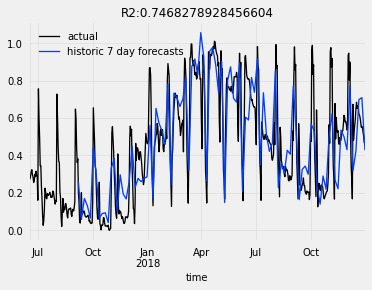

In [12]:
from darts.metrics import r2_score
import matplotlib.pyplot as plt
series_transformed[900:]['0'].plot(label='actual')
pred_series.plot(label=('historic 7 day forecasts'))
r2_score_value = r2_score(series_transformed['0'], pred_series)
plt.title('R2:' + str(r2_score_value))
plt.legend()